In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import seaborn as sns
import pandas as pd
import torch
# import pyro.distributions as dist
# from pyro.ops.tensor_utils import convolve
import torch.nn.functional as torch_F
import math
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
df_counts_time = pd.read_csv('./4days_date.csv', header = 0)
time = pd.to_datetime(df_counts_time['date'], format='%Y-%m-%d')

lineages = torch.load('./Omicron_experimental_data_new.pkl')['lineages']
country = torch.load('./Omicron_experimental_data_new.pkl')['locations']

counts_real = torch.load('./Omicron_experimental_data_new.pkl')['counts']
counts = counts_real / (counts_real.sum(-1).unsqueeze(-1))

counts1 = counts.numpy()
counts = np.nan_to_num(counts1)

In [3]:
def get_lineage_index(list):
    index = []
    for i in range(len(list)):
        index.append(lineages.index(list[i]))
    return index

In [4]:
## get counts & forecast data
def get_counts(country_index, lineage_index):
    df_counts = pd.DataFrame(counts[:, country_index, lineage_index])
    return df_counts

def get_forecast(country_index, lineage_index, forecast):
    df_forecast = pd.DataFrame(forecast[:, country_index, lineage_index].squeeze(1))
    return df_forecast

## country submission

In [5]:
## get index of country
country_index1 = country.index('USA')
country_index2 = country.index('UnitedKingdom')
country_index3 = country.index('Germany')
country_index4 = country.index('France')
country_index5 = country.index('Brazil')
country_index6 = country.index('Poland')

# lineage = ['BA.1.1','BA.2', 'BA.2.12.1', 'BA.5.1','BA.5.2', 'BF.7', 'BQ.1.1', 'XBB.1.5', 'XBB.1.9.1', 'XBB.1.16', 'EG.5.1']
lineage = ['BA.1.1','BA.1.15','BA.2','BA.2.12.1', 'BA.5.1','BA.5.2.1', 'BQ.1.1','XBB.1.5', 'XBB.1.9.1', 'XBB.1.16', 'EG.5.1', 'HK.3', 'JN.1']
colors = cm.rainbow(np.arange(len(lineage))/len(lineage))

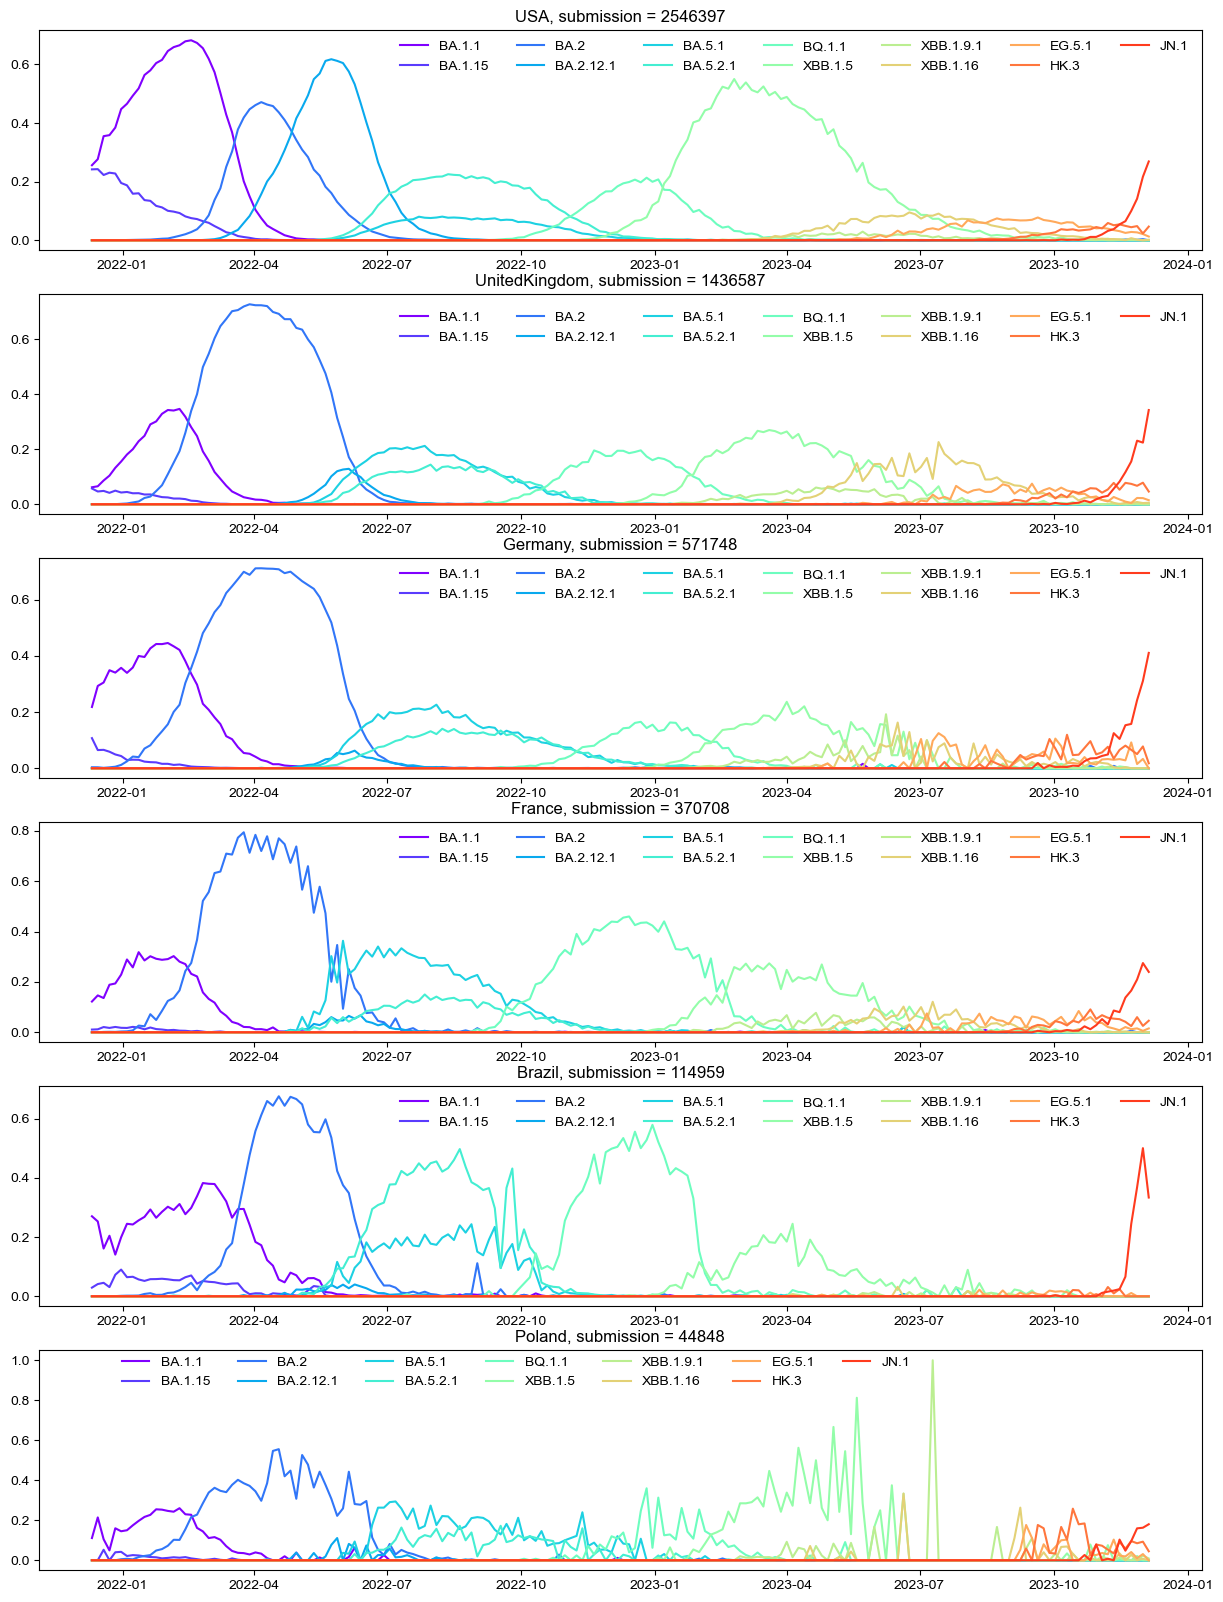

In [52]:
plt.figure(figsize=(15,20))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 10, 192

fig = plt.subplot(611)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index1, get_lineage_index(lineage))[m:n][i], color = colors[i],label=lineage[i])
    plt.legend(frameon=False,bbox_to_anchor=(0.3,0.75),ncol=7)
    plt.title(country[country_index1]+', submission = '+str(int(counts_real[:,country_index1,:].sum().tolist())))

fig = plt.subplot(612)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index2, get_lineage_index(lineage))[m:n][i], color = colors[i],label=lineage[i])
    plt.legend(frameon=False,bbox_to_anchor=(0.3,0.98),ncol=7)
    plt.title(country[country_index2]+', submission = '+str(int(counts_real[:,country_index2,:].sum().tolist())))

fig = plt.subplot(613)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index3, get_lineage_index(lineage))[m:n][i], color = colors[i],label=lineage[i])
    plt.legend(frameon=False,bbox_to_anchor=(0.3,0.75),ncol=7)
    plt.title(country[country_index3]+', submission = '+str(int(counts_real[:,country_index3,:].sum().tolist())))

fig = plt.subplot(614)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index4, get_lineage_index(lineage))[m:n][i], color = colors[i],label=lineage[i])
    plt.legend(frameon=False,bbox_to_anchor=(0.3,0.75),ncol=7)
    plt.title(country[country_index4]+', submission = '+str(int(counts_real[:,country_index4,:].sum().tolist())))

fig = plt.subplot(615)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index5, get_lineage_index(lineage))[m:n][i], color = colors[i],label=lineage[i])
    plt.legend(frameon=False,bbox_to_anchor=(0.3,0.75),ncol=7)
    plt.title(country[country_index5]+', submission = '+str(int(counts_real[:,country_index5,:].sum().tolist())))

fig = plt.subplot(616)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index6, get_lineage_index(lineage))[m:n][i], color = colors[i],label=lineage[i])
    plt.legend(frameon=False,bbox_to_anchor=(0.76,0.77),ncol=7)
    plt.title(country[country_index6]+', submission = '+str(int(counts_real[:,country_index6,:].sum().tolist())))

## country forecast and fitting

In [96]:
## get index of country
country_index1 = country.index('USA')
country_index2 = country.index('UnitedKingdom')
country_index3 = country.index('Germany')
country_index4 = country.index('France')
country_index5 = country.index('Brazil')
country_index6 = country.index('Poland')

# lineage = ['BA.1.1','BA.2', 'BA.2.12.1', 'BA.5.1','BA.5.2', 'BF.7', 'BQ.1.1', 'XBB.1.5', 'XBB.1.9.1', 'XBB.1.16', 'EG.5.1']
lineage = ['BA.1.1','BA.1.15','BA.2','BA.2.12.1', 'BA.5.1','BA.5.2.1', 'BQ.1.1','XBB.1.5', 'XBB.1.9.1', 'XBB.1.16', 'EG.5.1', 'HK.3', 'JN.1']
colors = cm.rainbow(np.arange(len(lineage))/len(lineage))

In [97]:
forecast_AE = torch.load('./10phase_AE_41_reparam.pkl', map_location=torch.device('cpu'))
forecast_noAE = torch.load('./10phase_noAE_41_new.pkl', map_location=torch.device('cpu'))
forecast_random = torch.load('./10phase_random_41_new.pkl', map_location=torch.device('cpu'))
forecast_noSite = torch.load('./10phase_noSite_41_new.pkl', map_location=torch.device('cpu'))

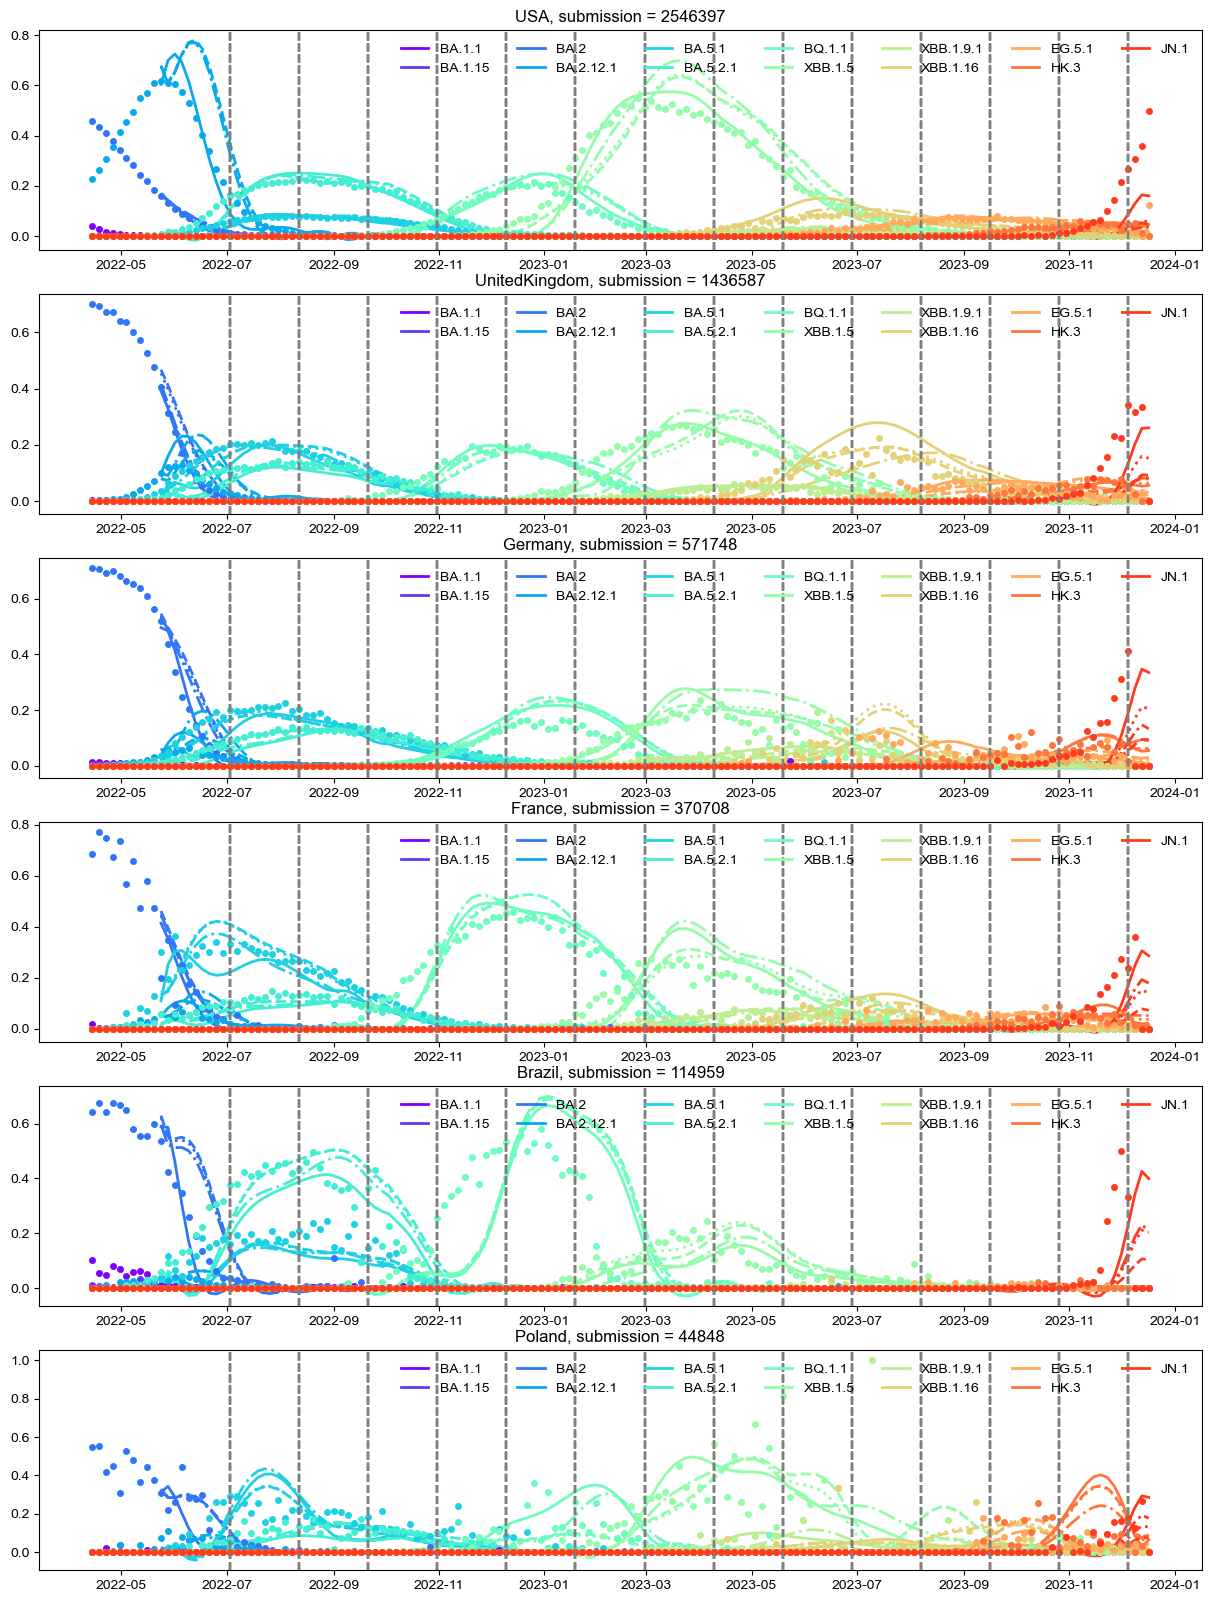

In [98]:
plt.figure(figsize=(15,20))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 51, 195
s = 41
fig = plt.subplot(611)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index1, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index1, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index1]+', submission = '+str(int(counts_real[:,country_index1,:].sum().tolist())))
    for i in range(int((n-m)/10)):
        plt.axvline(x=time[m+10+10*i], linestyle='--', color='grey')

fig = plt.subplot(612)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index2, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index2, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index2, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index2, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index2, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index2, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index2]+', submission = '+str(int(counts_real[:,country_index2,:].sum().tolist())))
    for i in range(int((n-m)/10)):
        plt.axvline(x=time[m+10+10*i], linestyle='--', color='grey')

fig = plt.subplot(613)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index3, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index3, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index3, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index3, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index3, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index3, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index3]+', submission = '+str(int(counts_real[:,country_index3,:].sum().tolist())))
    for i in range(int((n-m)/10)):
        plt.axvline(x=time[m+10+10*i], linestyle='--', color='grey')

fig = plt.subplot(614)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index4, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index4, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index4, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index4, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index4, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index4, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index4]+', submission = '+str(int(counts_real[:,country_index4,:].sum().tolist())))
    for i in range(int((n-m)/10)):
        plt.axvline(x=time[m+10+10*i], linestyle='--', color='grey')

fig = plt.subplot(615)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index5, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index5, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index5, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index5, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index5, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index5, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    # plt.legend(frameon=False,bbox_to_anchor=(0.42575,0.75),ncol=7)
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index5]+', submission = '+str(int(counts_real[:,country_index5,:].sum().tolist())))
    for i in range(int((n-m)/10)):
        plt.axvline(x=time[m+10+10*i], linestyle='--', color='grey')

fig = plt.subplot(616)
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index6, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index6, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index6, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index6, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index6, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index6, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index6]+', submission = '+str(int(counts_real[:,country_index6,:].sum().tolist())))
    for i in range(int((n-m)/10)):
        plt.axvline(x=time[m+10+10*i], linestyle='--', color='grey')

In [94]:
forecast_AE = torch.load('./fitting_AE_reparam.pkl', map_location=torch.device('cpu'))
forecast_noAE = torch.load('./fitting_noAE_reparam.pkl', map_location=torch.device('cpu'))
forecast_random = torch.load('./fitting_random_reparam.pkl', map_location=torch.device('cpu'))
forecast_noSite = torch.load('./fitting_noSite_reparam.pkl', map_location=torch.device('cpu'))

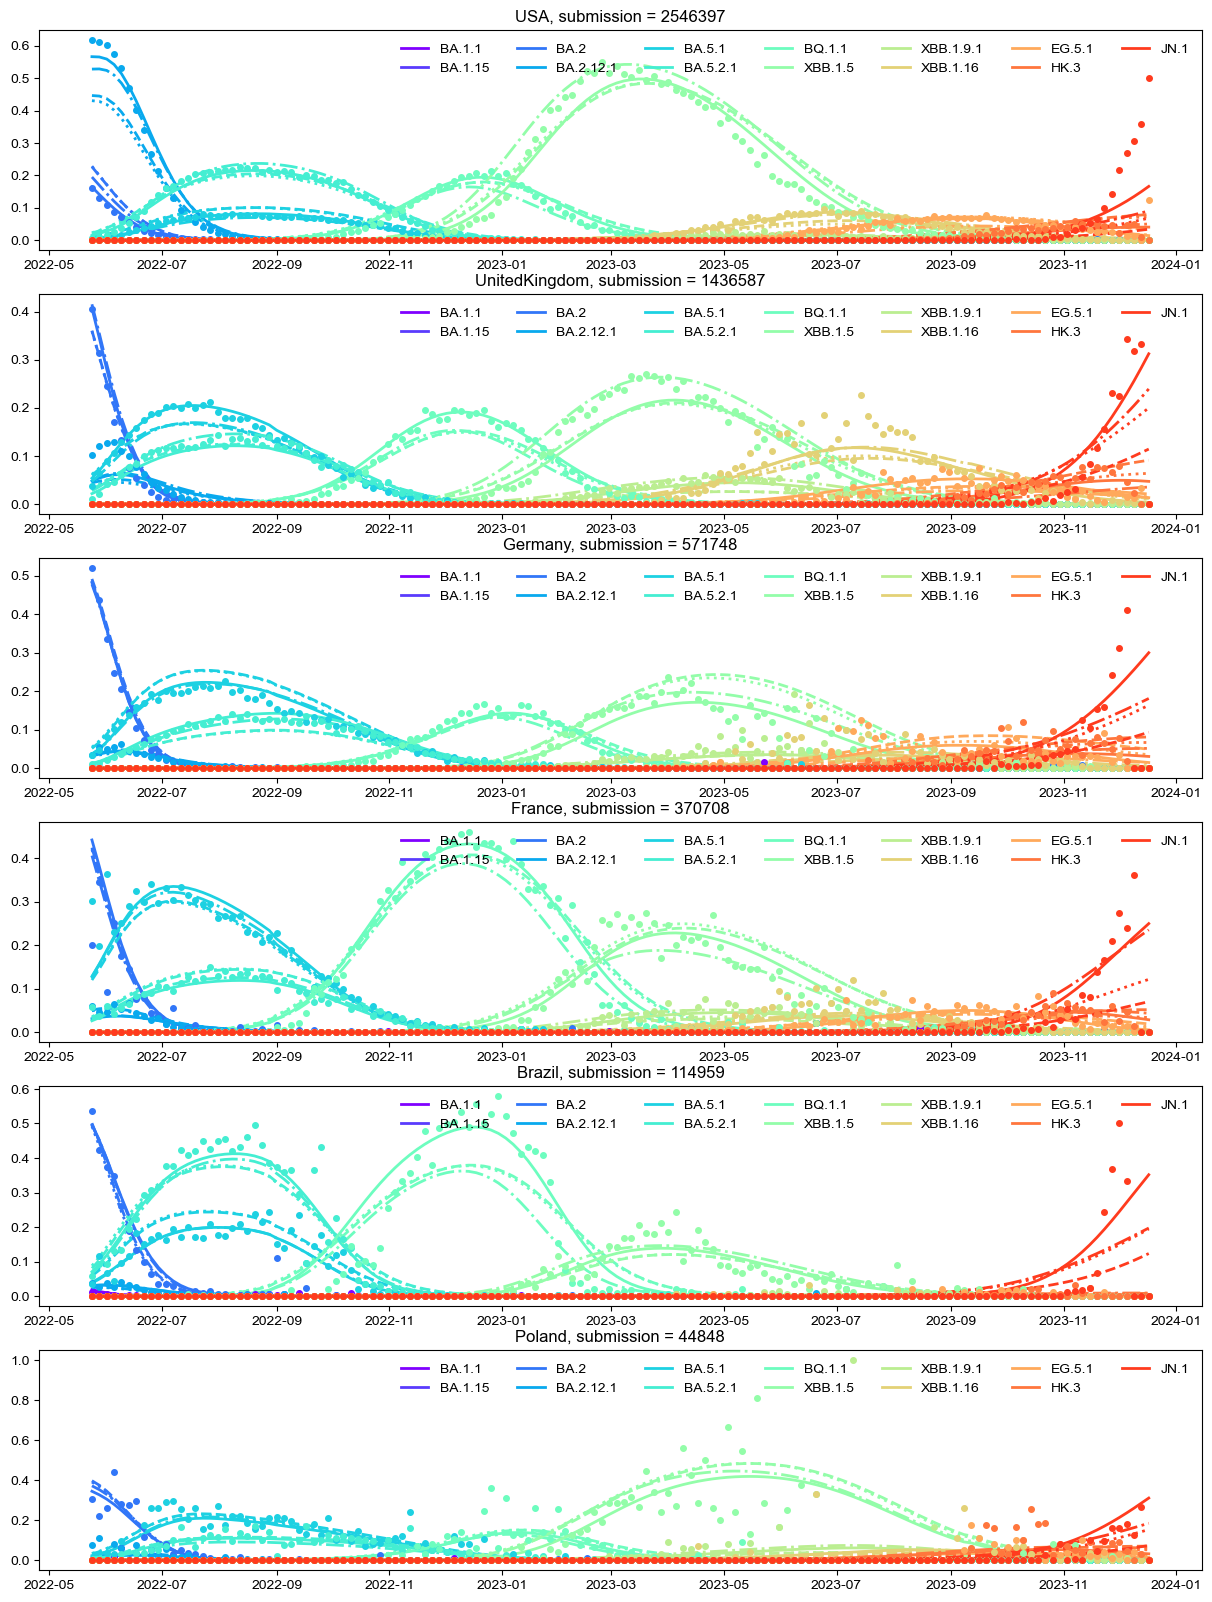

In [95]:
plt.figure(figsize=(15,20))
plt.rcParams['font.sans-serif'] = 'Arial'
m, n = 51, 195
s = 41
fig = plt.subplot(611)
for i in range(len(lineage)):
    # plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index1, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index1, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index1]+', submission = '+str(int(counts_real[:,country_index1,:].sum().tolist())))


fig = plt.subplot(612)
for i in range(len(lineage)):
    # plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index2, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index2, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index2, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index2, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index2, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index2, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index2]+', submission = '+str(int(counts_real[:,country_index2,:].sum().tolist())))


fig = plt.subplot(613)
for i in range(len(lineage)):
    # plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index3, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index3, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index3, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index3, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index3, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index3, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index3]+', submission = '+str(int(counts_real[:,country_index3,:].sum().tolist())))


fig = plt.subplot(614)
for i in range(len(lineage)):
    # plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index4, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index4, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index4, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index4, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index4, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index4, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index4]+', submission = '+str(int(counts_real[:,country_index4,:].sum().tolist())))


fig = plt.subplot(615)
for i in range(len(lineage)):
    # plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index5, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index5, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index5, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index5, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index5, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index5, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    # plt.legend(frameon=False,bbox_to_anchor=(0.42575,0.75),ncol=7)
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index5]+', submission = '+str(int(counts_real[:,country_index5,:].sum().tolist())))

fig = plt.subplot(616)
for i in range(len(lineage)):
    # plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index6, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index6, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=4)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index6, get_lineage_index(lineage), forecast_AE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index6, get_lineage_index(lineage), forecast_noAE)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='--')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index6, get_lineage_index(lineage), forecast_random)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle='-.')
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index6, get_lineage_index(lineage), forecast_noSite)[m:n][i], 50, 10), color = colors[i], lw=2, zorder=-9, linestyle=':')
    plt.legend(frameon=False,loc='upper right',ncol=7)
    plt.title(country[country_index6]+', submission = '+str(int(counts_real[:,country_index6,:].sum().tolist())))

## bad forecast performance of XBB.1.5 and JN.1

In [7]:
df_counts_time = pd.read_csv('./4days_date.csv', header = 0)
time = pd.to_datetime(df_counts_time['date'], format='%Y-%m-%d')

lineages = torch.load('./Omicron_experimental_data_new.pkl')['lineages']
country = torch.load('./Omicron_experimental_data_new.pkl')['locations']

counts = torch.load('./Omicron_experimental_data_new.pkl')['counts']
counts = counts / (counts.sum(-1).unsqueeze(-1))

counts1 = counts.numpy()
counts = np.nan_to_num(counts1)

In [32]:
forecast_result_4 = torch.load('./10phase_AE_41_reparam.pkl', map_location=torch.device('cpu'))

In [25]:
def get_lineage_index(list):
    index = []
    for i in range(len(list)):
        index.append(lineages.index(list[i]))
    return index

## get counts & forecast data
def get_counts(country_index, lineage_index):
    df_counts = pd.DataFrame(counts[:, country_index, lineage_index])
    return df_counts

def get_forecast(country_index, lineage_index, forecast):
    df_forecast = pd.DataFrame(forecast[:, country_index, lineage_index].squeeze(1))
    return df_forecast

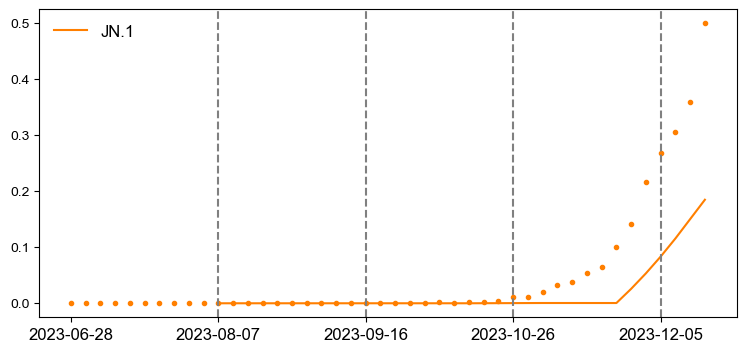

In [34]:
plt.figure(figsize=(9,4))
plt.rcParams['font.sans-serif'] = ['Arial']
country_index1 = country.index('USA')

# lineage = ['XBB.1.5']
# colors = ['#b1d85c']
lineage = ['JN.1']
colors = ['#FF7F00']
s = 151
m,n = 161,195
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index1, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=3)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index1, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=3)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_result_4)[m:n][i], 5, 1), color = colors[i], lw=1.5, zorder=-9, label = lineage[i])

plt.legend(frameon=False, loc='upper left', fontsize=12)
plt.axvline(x=time[m],linestyle='--', color='grey')
plt.axvline(x=time[m+10],linestyle='--', color='grey')
plt.axvline(x=time[m+20],linestyle='--', color='grey')
plt.axvline(x=time[m+30],linestyle='--', color='grey')
# plt.axvline(x=time[m+40],linestyle='--', color='grey')

datetime_plot = []
string_plot = []
for i in range(n - s):
    if i % 10 == 0:
        datetime_plot.append(time[i + s])
        string_plot.append(time[i + s].strftime('%Y-%m-%d'))
plt.xticks(datetime_plot, string_plot, fontsize=12)

## growth forecast

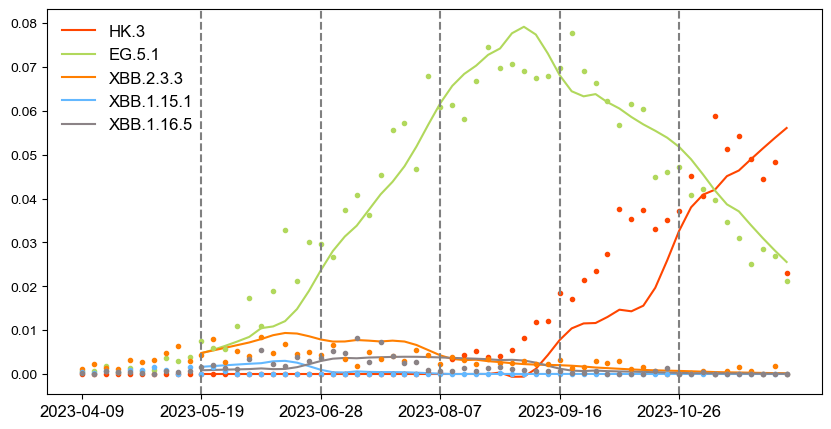

In [57]:
forecast_result_4 = torch.load('./10phase_AE_41_reparam.pkl', map_location=torch.device('cpu'))

plt.figure(figsize=(10,5))
plt.rcParams['font.sans-serif'] = ['Arial']
country_index1 = country.index('USA')

# lineage = ['XBB.1.16', 'XBB.1.5', 'XBB.1.9', 'FD.2', 'XBB.2.2', 'FL.4', 'FU.1']
# colors = ['#FF4500', '#b1d85c', '#FF7F00', '#63B8FF', '#8B8386', '#FFAEB9', '#8470FF']
lineage = ['HK.3', 'EG.5.1', 'XBB.2.3.3', 'XBB.1.15.1', 'XBB.1.16.5']
s = 131
m,n = 141,191
for i in range(len(lineage)):
    plt.plot(time[:counts.shape[0]][s:m], get_counts(country_index1, get_lineage_index(lineage))[s:m][i], color = colors[i], lw=0, marker='o', markersize=3)
    plt.plot(time[:counts.shape[0]][m:n], get_counts(country_index1, get_lineage_index(lineage))[m:n][i], color = colors[i], lw=0, marker='o', markersize=3)
    plt.plot(time[:counts.shape[0]][m:n], savgol_filter(get_forecast(country_index1, get_lineage_index(lineage), forecast_result_4)[m:n][i], 10, 5), color = colors[i], lw=1.5, zorder=-9, label = lineage[i])

plt.legend(frameon=False, loc='upper left', fontsize=12)
plt.axvline(x=time[m],linestyle='--', color='grey')
plt.axvline(x=time[m+10],linestyle='--', color='grey')
plt.axvline(x=time[m+20],linestyle='--', color='grey')
plt.axvline(x=time[m+30],linestyle='--', color='grey')
plt.axvline(x=time[m+40],linestyle='--', color='grey')

datetime_plot = []
string_plot = []
for i in range(n - s):
    if i % 10 == 0:
        datetime_plot.append(time[i + s])
        string_plot.append(time[i + s].strftime('%Y-%m-%d'))
plt.xticks(datetime_plot, string_plot, fontsize=12)